In [1]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
import scipy.optimize as optimize
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### The full evolutionary trajectories from a mock simulation of 50 paralog pairs are imported: 

In [3]:
data_full = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Full_data_WGD/data_all_Bm1_full.csv')
data_full = data_full[data_full['Model'] == 'Mixed'].reset_index(drop=True)

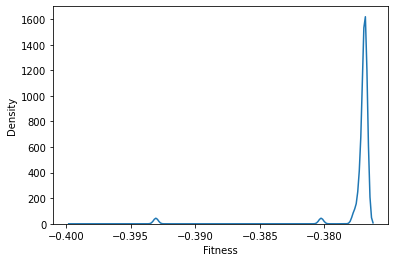

In [4]:
sns.kdeplot(np.log10(data_full['Fitness']))

In [5]:
# Definition of a function to plot all trajectories for one property on the
# same figure (with the appropriate color code, so that the most expressed copy
# is in orange and the least expressed one is in blue)
def div_fig(sim_log2, P1_left, P1_right, means_P1, means_P2, means_both,
            gene_prop, ax):
  """Function to plot the evolutionary trajectories throughout the 
  mutation-selection rounds.
  
  sim_log2 = dataframe of log2 fold-changes at each mutation-selection round
  gene_prop = string representing the property to be plotted (either Bm, Bp,
             Prot or cv)
  ax = ax object on which to plot"""

  col_P1 = f'{gene_prop}1'
  col_P2 = f'{gene_prop}2'
  
  # Trajectories are plotted
  widths = 0.10
  opacity = 0.5
  
  for P1 in list(P1_left[0]):
    # Here, paralog 1 (most expressed) is on the left of the df
    subset = sim_log2[sim_log2['Couple'] == P1].copy()
    
    ax.plot(subset['Round'], subset[col_P1], c=cm.tab20.colors[3], 
            alpha=opacity, linewidth=widths)
    ax.plot(subset['Round'], subset[col_P2], c=cm.tab20.colors[1], 
            alpha=opacity, linewidth=widths)
    
  for P1 in list(P1_right[0]):
    # Here, paralog 1 (most expressed) is on the right of the df (identified as '2')
    subset = sim_log2[sim_log2['Couple'] == P1].copy()
    
    ax.plot(subset['Round'], subset[col_P2], c=cm.tab20.colors[3], 
            alpha=opacity, linewidth=widths)
    ax.plot(subset['Round'], subset[col_P1], c=cm.tab20.colors[1], 
            alpha=opacity, linewidth=widths)
    
  # Mean for P1
  ax.plot(means_P1['Round'], means_P1[gene_prop], c=cm.tab10.colors[1], 
          label='Most expressed')

  # Mean for P2
  ax.plot(means_P2['Round'], means_P2[gene_prop], c=cm.tab10.colors[0], 
          label='Least expressed')

  # Global mean
  ax.plot(means_both['Round'], means_both[gene_prop], c='k', label='All',
          alpha=0.65)

In [6]:
sim_data = data_full.copy()

In [7]:
# 1) Compute log2 fold-changes
init_rates = sim_data[sim_data['Round'] == 0].copy()
n_rounds = sim_data['Round'].max() + 1
init_tiled = np.tile(init_rates, (n_rounds, 1))

sim_log2 = sim_data.copy()

sim_log2.iloc[:, 5:11] = sim_log2.iloc[:, 5:11] / init_tiled[:, 5:11]
sim_log2 = sim_log2.infer_objects()
sim_log2.iloc[:, 5:11] = np.log2(sim_log2.iloc[:, 5:11])

# 2) Identify the most expressed copy within each pair
last_round = sim_data['Round'].max()
end_data = sim_data[sim_data['Round'] == last_round]

# Couples where the most expressed paralog (P1) is identified as P1
P1_left = np.where(end_data['Prot1'] >= end_data['Prot2'])

# Couples where the most expressed paralog (P1) is identified as P2
P1_right = np.where(end_data['Prot2'] >= end_data['Prot1'])

In [8]:
# 3) Aggregating data for P1 and P2 through time
means_P1 = pd.DataFrame(columns=['Round', 'Couple', 'Bm', 'Bp', 'Prot', 
                                     'cv'])
means_P2 = means_P1.copy()

for P1 in list(P1_left[0]):
  subset = sim_log2[sim_log2['Couple'] == P1]
    
  P1_subset = subset.iloc[:, np.r_[0:2, 5:7, 9, 11]].copy()
  P2_subset = subset.iloc[:, np.r_[0:2, 7:9, 10, 12]].copy()
  P1_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']
  P2_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']

  means_P1 = pd.concat([means_P1, P1_subset])
  means_P2 = pd.concat([means_P2, P2_subset])

for P1 in list(P1_right[0]):
  subset = sim_log2[sim_log2['Couple'] == P1]

  P1_subset = subset.iloc[:, np.r_[0:2, 7:9, 10, 12]].copy()
  P2_subset = subset.iloc[:, np.r_[0:2, 5:7, 9, 11]].copy()
  P1_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']
  P2_subset.columns = ['Round', 'Couple', 'Bm', 'Bp', 'Prot', 'cv']

  means_P1 = pd.concat([means_P1, P1_subset])
  means_P2 = pd.concat([means_P2, P2_subset])

In [9]:
  means_both = pd.concat([means_P1, means_P2])
  means_both.iloc[:, 2:] = 2**means_both.iloc[:, 2:6]
  means_both = means_both.groupby(by='Round', as_index=False).mean()
  means_both.iloc[:, 1:] = np.log2(means_both.iloc[0:, 1:5])

  means_P1.iloc[:, 2:] = 2**means_P1.iloc[:, 2:6]
  means_P1 = means_P1.groupby(by='Round', as_index=False).mean()
  means_P1.iloc[:, 1:] = np.log2(means_P1.iloc[0:, 1:5])

  means_P2.iloc[:, 2:] = 2**means_P2.iloc[:, 2:6]
  means_P2 = means_P2.groupby(by='Round', as_index=False).mean()
  means_P2.iloc[:, 1:] = np.log2(means_P2.iloc[0:, 1:5])

### The distributions of the final log2 fold-changes for the same mock simulations are also used

In [10]:
# Function to compute log2 fold-changes between two paralogs
def fold_change(prop_P1, prop_P2, data):
    """Function to calculate log2 fold-change for a property between two duplicates. The two properties are
    provided as dataframe columns, and a dataframe column containing the log2 fold-changes is returned."""

    df = data[[f'{prop_P1}', f'{prop_P2}']].copy()
    df['Fold_Change'] = np.NaN

    for row in range(df.shape[0]):
        value_P1 = df.at[row, f'{prop_P1}']
        value_P2 = df.at[row, f'{prop_P2}']

        if value_P1 == 0 or value_P2 == 0:
            continue

        if value_P1 >= value_P2:
            df.at[row, 'Fold_Change'] = value_P1/value_P2

        elif value_P1 < value_P2:
            df.at[row, 'Fold_Change'] = value_P2/value_P1

    df['Fold_Change'] = np.log2(df['Fold_Change'])

    return df['Fold_Change']

In [11]:
mock_final = data_full[data_full['Round'] == data_full['Round'].max()].copy().reset_index(drop=True)

mock_final[r"$\beta_m$"] = fold_change('Bm1', 'Bm2', mock_final)
mock_final[r"$\beta_p$"] = fold_change('Bp1', 'Bp2', mock_final)
mock_final[r"$P$"] = fold_change('Prot1', 'Prot2', mock_final)

folds_mock = mock_final[[r"$\beta_m$", r"$\beta_p$", r"$P$"]].copy()
folds_mock = folds_mock.melt(var_name='Property', value_name=r"$Log_2$ fold-change")

### Quick validation before constructing the final figure: Is the expression noise of the pair (summed variance and/or total cv) reduced during the in silico evolution? If this was the case, it would change our interpretation that the bias towards transcriptional changes is due to interactions between mutations.

In [12]:
# Function to compute the summed variance (used in the simulations)
def variance_dupli(bm1, bm2, p1, p2, alpha_p, cv_0):
    """Function to compute the variance of protein abundance for many duplicate couples at once. The transcription rates
    (bm1 and bm2) and protein abundances (p1 and P2) for each couple are provided as np arrays and an array containing
     the variances for each couple is returned. The variables alpha_p and cv_0 are constants (protein decay rate and
     noise floor) and only need to be provided as floats. It is used in the fit_noise_dupli function below.

    bm1, bm2 = Transcription rate of paralogs P1 and P2, respectively (in mRNA per hour)
    p1, p2 = Protein abundance of paralogs P1 and P2, respectively (in proteins per cell)"""

    with np.errstate(divide='ignore', invalid='ignore'):
        # To avoid warnings raised when p1 == 0 or p2 == 0, since np.where first applies the operation to all elements
        # before testing the condition
        intrinsic_p1 = np.where(p1 == 0, 0, (p1**2) * ((1/p1) + (alpha_p/bm1)))
        intrinsic_p2 = np.where(p2 == 0, 0, (p2**2) * ((1/p2) + (alpha_p/bm2)))

    extrinsic_tot = (np.sqrt((p1**2) * (cv_0**2)) + np.sqrt((p2**2) * (cv_0**2)))**2
    var_tot = intrinsic_p1 + intrinsic_p2 + extrinsic_tot

    return var_tot

In [13]:
data_full['variance_tot'] = variance_dupli(data_full['Bm1'], data_full['Bm2'],
                                           data_full['Prot1'], data_full['Prot2'],
                                           1.34, 0.1)
data_full['log10_var_tot'] = np.log10(data_full['variance_tot'])

data_full['cv_global'] = np.sqrt(data_full['variance_tot']) / (data_full['Prot1'] + data_full['Prot2'])

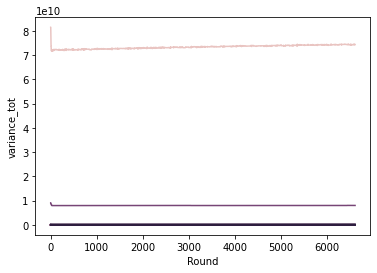

In [14]:
sns.lineplot(x='Round', y='variance_tot', hue='Couple',
             data=data_full, legend=None)

(0.0, 1000.0)

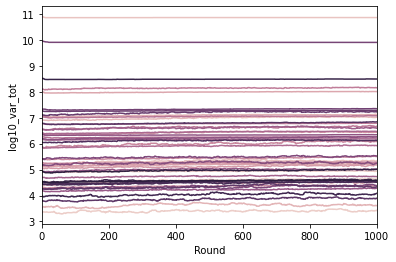

In [15]:
sns.lineplot(x='Round', y='log10_var_tot', hue='Couple',
             data=data_full, legend=None)
ax = plt.gca()
ax.set_xlim(0, 1000)

(0.0, 1000.0)

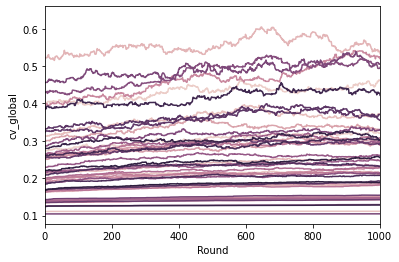

In [16]:
sns.lineplot(x='Round', y='cv_global', hue='Couple',
             data=data_full, legend=None)
ax = plt.gca()
ax.set_xlim(0, 1000)

### The final figure is constructed:

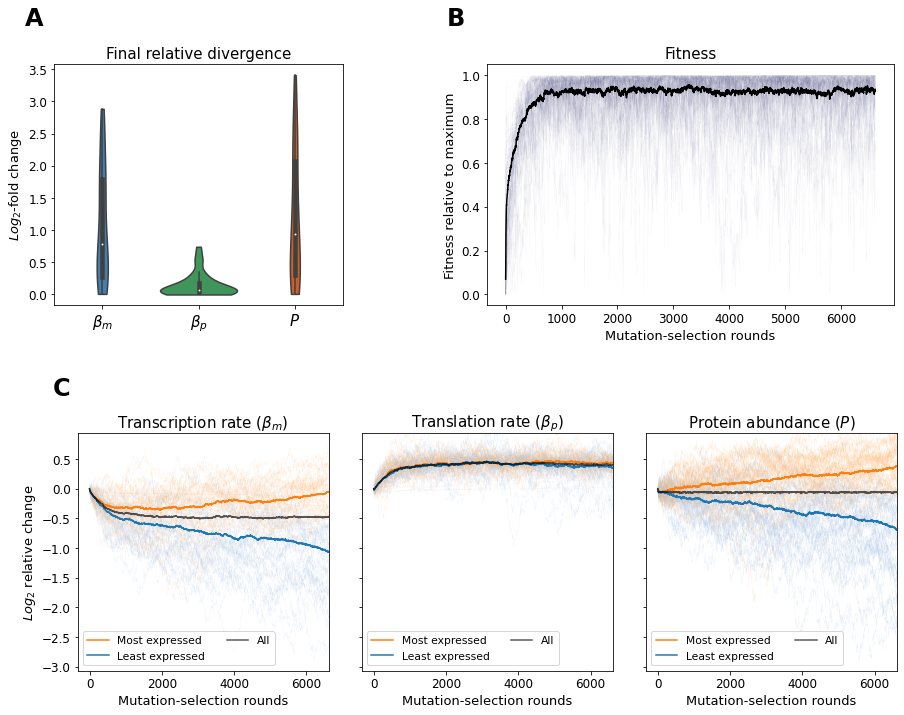

In [17]:
fig = plt.figure(constrained_layout=False, figsize=(17, 10))

# Preparation of the grids
gs1 = fig.add_gridspec(nrows=8, ncols=8, left=0.08, right=0.35, bottom=0.50, 
                       top=0.95, wspace=0.05)
ax1 = fig.add_subplot(gs1[1:7, 1:8])

gs2 = fig.add_gridspec(nrows=8, ncols=8, left=0.42, right=0.8, bottom=0.50, 
                       top=0.95, wspace=0.05)
ax2 = fig.add_subplot(gs2[1:7, 1:8])

gs3 = fig.add_gridspec(nrows=2, ncols=33, left=0.03, right=0.88, bottom=0.05, 
                       top=0.38, wspace=0.05)
ax3 = fig.add_subplot(gs3[:, 4:12])
ax4 = fig.add_subplot(gs3[:, 13:21])
ax5 = fig.add_subplot(gs3[:, 22:30])

# Final relative divergence for the mock simulation 
sns.violinplot(x='Property', y=r"$Log_2$ fold-change", data=folds_mock,
               cut=0, order=[r"$\beta_m$", r"$\beta_p$", r"$P$"],
               palette=[cm.tab20c.colors[0], cm.tab20c.colors[8],
                        cm.tab20c.colors[4]], ax=ax1)

ax1.set_ylabel(r"$Log_2$-fold change", fontsize=13)
ax1.set_xlabel('')

# Fitness through time
rel_fit = pd.DataFrame(columns=data_full.columns)
for pair in data_full['Couple'].unique():
  pair_sub = data_full[data_full['Couple'] == pair].copy()
  pair_sub['Fitness'] = (pair_sub['Fitness'] - pair_sub['Fitness'].min())/(pair_sub['Fitness'].max() - pair_sub['Fitness'].min())

  rel_fit = pd.concat([rel_fit, pair_sub], axis=0)

  ax2.plot(pair_sub['Round'], pair_sub['Fitness'], c=cm.tab20b.colors[0],
           alpha=0.15, linewidth=0.075)
  
# Addition of the mean
data_mean = rel_fit.groupby(by='Round', as_index=False).mean()
ax2.plot(data_mean['Round'], data_mean['Fitness'], c='k')

# Divergence through time for the mock simulation under the cost-precision
# trade-off
div_fig(sim_log2, P1_left, P1_right, means_P1, means_P2, means_both, 'Bm', ax3)

div_fig(sim_log2, P1_left, P1_right, means_P1, means_P2, means_both, 'Bp', ax4)

div_fig(sim_log2, P1_left, P1_right, means_P1, means_P2, means_both, 'Prot',
        ax5)

ax3.legend(fontsize=10.75, ncol=2)
ax4.legend(fontsize=10.75, ncol=2)
ax5.legend(fontsize=10.75, ncol=2)

# Manual corection of y axes
for ax in [ax4, ax5]:
  ax.set_ylabel('')
  ax.tick_params(labelleft=False)
  ax.set_ylim(ax3.get_ylim())

# Axes labels
ax2.set_xlabel(r'Mutation-selection rounds', fontsize=13)
ax2.set_ylabel('Fitness relative to maximum', fontsize=13)

ax3.set_ylabel(r"$Log_2$ relative change", fontsize=13)

ax3.set_xlabel('Mutation-selection rounds', fontsize=13)
ax4.set_xlabel('Mutation-selection rounds', fontsize=13)
ax5.set_xlabel('Mutation-selection rounds', fontsize=13)

# Manual setting of the xlims
for ax in [ax3, ax4, ax5]:
    ax.set_xlim(right=data_full['Round'].max())

# Manual setting of tick labels
for ax in [ax1, ax2, ax3, ax4, ax5]:
  ax.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='x', which='major', labelsize=15)

# Plot titles
ax1.set_title('Final relative divergence', fontsize=15)
ax2.set_title('Fitness', fontsize=15)
ax3.set_title(r"Transcription rate ($\beta_m$)", fontsize=15)
ax4.set_title(r"Translation rate ($\beta_p$)", fontsize=15)
ax5.set_title(r"Protein abundance ($P$)", fontsize=15)

# Annotation of subfigures A, B and C
ax1.annotate('A', (-0.1, 1.16), xycoords='axes fraction',
             fontsize=24, fontweight="bold")

ax2.annotate('B', (-0.1, 1.16), xycoords='axes fraction',
             fontsize=24, fontweight="bold")

ax3.annotate('C', (-0.1, 1.16), xycoords='axes fraction',
             fontsize=24, fontweight="bold")

# Saving the figure
Fig3 = plt.gcf()
Fig3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Fig3.tiff',
             bbox_inches='tight')